### 최종 앙상블한 submission.csv에서 엄청 작거나 엄청 큰 bbox들을 제거해보자.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2


def category_distribution(path):
    preds = pd.read_csv(path)

    category_distribution = [0 for _ in range(10)]
    no_object_cnt = 0

    for pred in preds['PredictionString']:
        try:
            splitted_preds = pred.split()
        except:
            no_object_cnt += 1
            continue
    
        for idx in range(0, len(splitted_preds), 6):
            category_id = int(splitted_preds[idx])
            confidence_score = float(splitted_preds[idx+1])

            category_distribution[category_id] += 1
                
    print('테스트 데이터에 대하여, 모델이 예측한 bbox들의 클래스 분포')
    print(category_distribution, 'total : ', sum(category_distribution))
    print(no_object_cnt)

    total_boxes = sum(category_distribution)
    ratios = [x / total_boxes for x in category_distribution]
    labels = ['General trash', 'Paper', 'Paper pack', 'Metal', 'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothing']

    plt.pie(ratios, labels=labels, autopct="%.1f%%")
    plt.show()


def show_bbox_distribution(path):
    # csv load
    model_preds = pd.read_csv(path)

    bbox_areas = [0 for _ in range(3)] # small, medium, large

    no_object_cnt = 0
    for preds in model_preds['PredictionString']:
        try:
            splitted_preds = preds.split()
        except:
            no_object_cnt += 1
            continue

        for idx in range(0, len(splitted_preds), 6):
            category_id = int(splitted_preds[idx])
            confidence_score = float(splitted_preds[idx+1])
            x_min, y_min, x_max, y_max = [float(x) for x in splitted_preds[idx+2:idx+6]]

            bbox_area = (x_max - x_min) * (y_max - y_min) # widht * height = bbox area

            if bbox_area < 32**2: # small bbox
                bbox_areas[0] += 1
            elif bbox_area > 32**2 and bbox_area < 96**2:
                bbox_areas[1] += 1
            elif bbox_area > 96**2:
                bbox_areas[2] += 1

    total_bboxes = sum(bbox_areas)
    areas_ratio = [x / total_bboxes for x in bbox_areas]

    plt.pie(areas_ratio, labels=['small', 'medium', 'large'], autopct="%.1f%%")
    plt.show()

In [5]:
def all_visualization(path, num=10):
    df = pd.read_csv(path, index_col=False)
    class_dict = {0:'General trash', 1:'Paper', 2:'Paper pack', 3:'Metal', 4:'Glass',
                  5:'Plastic', 6:'Styrofoam', 7:'Plastic bag', 8:'Battery', 9:'Clothig'}
    class_colors = [(255, 153, 153), (255, 204, 153), (255, 255, 153),
                        (204, 255, 153), (153, 255, 255), (153, 153, 255),
                        (204, 153, 255), (255, 153, 255), (255, 153, 204), (255, 128, 0)]
    
    for idx, bboxes in enumerate(df['PredictionString'][:num]):
        image_path = '/opt/ml/dataset/' + df['image_id'][idx]
        images = cv2.imread(image_path)

        bbox = []
        temp =[]
        for text in bboxes.split(' '):
            if len(temp) < 6:
                temp.append(text)
            else:
                bbox.append(temp)
                temp = [text]
                
        for i in bbox:
            class_n, confidence, x_min, y_min, x_max, y_max = i
            images = cv2.rectangle(images, (int(float(x_min)), int(float(y_min))), (int(float(x_max)), int(float(y_max))), class_colors[int(class_n)], 2)
            images = cv2.putText(images, class_dict[int(class_n)], (int(float(x_min)), int(float(y_min))), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 1)

        plt.imshow(cv2.cvtColor(images, cv2.COLOR_BGR2RGB))
        plt.show()


테스트 데이터에 대하여, 모델이 예측한 bbox들의 클래스 분포
[139236, 105158, 20497, 38468, 24381, 72570, 32420, 92478, 8266, 21280] total :  554754
0


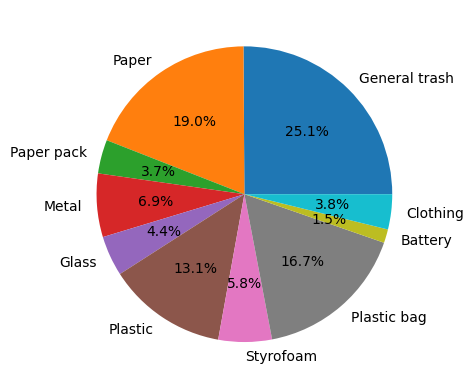

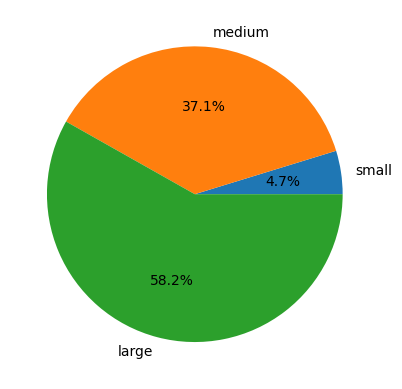

In [6]:
path = "/opt/ml/lb_best.csv"
category_distribution(path)
show_bbox_distribution(path)

### 너무 작거나, 너무 큰 bbox는 제거

- bbox 제거하기 이전의 시각화 결과

In [ ]:
all_visualization(path)

- bbox 제거하기

In [14]:
# 너무 작은 bbox와 너무 큰 bbox를 제거한다면??
# CSV 파일 불러오기
import pandas as pd

lb_best = pd.read_csv(path)

new_file_names = []
new_prediction_strings = []

orig_img_area = 1024 * 1024
removed_small_bbox = 0
removed_large_bbox = 0
for preds, file_name in zip(lb_best['PredictionString'], lb_best['image_id']):
    new_file_names.append(file_name)
    splitted_preds = preds.split()
    
    new_prediction_string = ''
    for idx in range(0, len(splitted_preds), 6):
        category_id = int(splitted_preds[idx])
        confidence_score = float(splitted_preds[idx+1])
        x_min, y_min, x_max, y_max = [float(x) for x in splitted_preds[idx+2:idx+6]]

        # 면적 계산
        bbox_area = (x_max - x_min) * (y_max - y_min) # width * height
        ratio = bbox_area / orig_img_area

        # 전체 이미지 대비 면적이 0.0005 이하라면
        if ratio <= 0.001:
            removed_small_bbox += 1
            continue

        # 전체 이미지 대비 면적이 0.99 이상이라면
        if ratio >= 0.8:
            removed_large_bbox += 1
            continue

        # 0.01보다는 크다면
        new_prediction_string += str(category_id) + ' ' + str(confidence_score) + ' ' + str(x_min) + ' ' + str(y_min) + ' ' + str(x_max) + ' ' + str(y_max) + ' '
    
    new_prediction_strings.append(new_prediction_string)

In [15]:
print(removed_small_bbox, removed_large_bbox)

27681 565


In [16]:
import os

new_submission = pd.DataFrame()
new_submission['PredictionString'] = new_prediction_strings
new_submission['image_id'] = new_file_names

csv_path = '/opt/ml/postprocessing/'

if not os.path.exists(csv_path):
    os.mkdir(csv_path)

new_submission.to_csv(os.path.join(csv_path, 'final.csv'), index=None)

테스트 데이터에 대하여, 모델이 예측한 bbox들의 클래스 분포
[130820, 100721, 19616, 35086, 22443, 69391, 31491, 88481, 7817, 20642] total :  526508
0


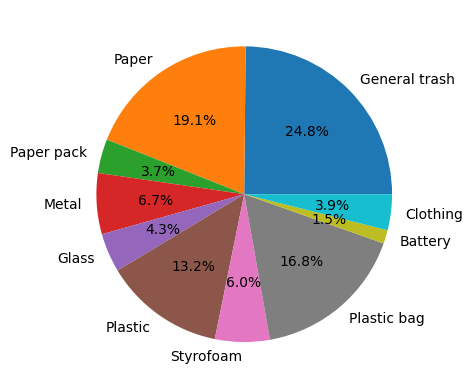

In [17]:
category_distribution("/opt/ml/postprocessing/final.csv")

In [ ]:
all_visualization("/opt/ml/postprocessing/final.csv")